In [1]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
import pandas as pd
import numpy as np
import re
from collections import Counter
import spacy
import spacy_universal_sentence_encoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from tensorflow.math import softplus
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import time
import warnings
from sklearn.preprocessing import LabelEncoder

In [2]:
# Sets the Ipython options

InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Design

# Sizes

title_size = 50
tick_size = 30
text_size = 30

In [4]:
# Functions


def clean_doc(text, pos_startegy=[], stop_words=[]):
    
    """Returns lemmatized and lowered document according to a given 
    POS filtering strategy and stop words list."""
    
    # Transforms the text in spacy's Doc object
    with nlp.select_pipes(disable=["ner"]):
        doc = nlp(text)
    
    # Lists the Doc's tokens lowered, lemmatized and POS filtered
    # Note : token.lemma_ doesn't returns lowered case tokens 
    # anymore hence the .lower()
    
    tokens = [token.lemma_.lower() for token in doc if token.pos_ in pos_startegy 
                                                    and not token.is_punct]

    # Removes stop words from a given stop words list
    # Note : the Spacy's token.is_stop has some buggs regarding to 
    # it's customization at the time this function is written 
    # hence the below coprehension list
    
    tokens = [i for i in tokens if i not in stop_words]
    
    # Returns the filtered, lemmatized, and lowered tokens joined
    
    return ' '.join(tokens)

def return_stop_words_list(serie, 
                           pos_startegy=[], 
                           most_common_threshold=30, 
                           rare_tokens_threshold=1):
    
    """Returns a list of stop words of a serie according to a given 
    POS filtering strategy, 
    most common words threshold and 
    rare occurences threshold.
    
    Stop words comes from :
    
    Default's Spacy stop words list
    Plus the most common words list
        (default threshold:30 most common words)
    Plus the rare words list
        (default threshold: 1 occurence)"""
    
    # Joins the texts of a serie to have one single text 
    
    serie = ' '.join(serie.values)
    
    # Transforms the text in spacy's Doc object
    with nlp.select_pipes(disable=["ner"]):
        doc = nlp(serie)
    
    # Lists the Doc's tokens lowered, lemmatized and POS filtered
    
    tokens = [token.lemma_.lower() for token in doc if token.pos_ in pos_startegy 
                                                    and not token.is_punct]
    
    
    # Creates a counter of the word occurences
    
    tokens_frequency = Counter(tokens)
    
    # Retrieves a list of the most common occurences
    
    most_common_tokens = list(
                            dict(
                                tokens_frequency
                                .most_common(most_common_threshold))
                                .keys())
    
    # Retrieves a list of the rare words
    
    rare_tokens = [i for i, j in tokens_frequency.items() if j == rare_tokens_threshold]
    
    # Retrieves the default spacy's stop words
    
    default_stop_words = list(nlp.Defaults.stop_words)
    
    # Returns the tree above created lists into one : a stop word list 
    
    return default_stop_words + most_common_tokens + rare_tokens



def clean_doc_oov(text, embedder, pos_startegy=[], stop_words=[]):
    
    """Returns lemmatized and lowered document according to a given 
    POS filtering strategy and stop words list."""
    
    # Transforms the text in spacy's Doc object
    
    doc = nlp(text)
    
    # Lists the Doc's tokens lowered, lemmatized and POS filtered
    # Note : token.lemma_ doesn't returns lowered case tokens 
    # anymore hence the .lower()
    
    tokens = [token.lemma_.lower() for token in doc if token.pos_ in pos_startegy 
                                                    and not token.is_punct]
    
    # Removes OOV for spacy mean accuracy
    
    doc_for_oov = embedder(' '.join(tokens))
    
    tokens = [token.text for token in doc_for_oov if not token.is_oov 
                                                  and not token.is_punct]
    
    # Removes stop words from a given stop words list
    # Note : the Spacy's token.is_stop has some buggs regarding to 
    # it's customization at the time this function is written 
    # hence the below coprehension list
    
    tokens = [i for i in tokens if i not in stop_words]
    
    # Returns the filtered, lemmatized, and lowered tokens joined
    
    return ' '.join(tokens)


def return_stop_words_list_oov(serie, embedder, 
                           pos_startegy=[], 
                           most_common_threshold=30, 
                           rare_tokens_threshold=1):
    
    """Returns a list of stop words of a serie according to a given 
    POS filtering strategy, 
    most common words threshold and 
    rare occurences threshold.
    
    Stop words comes from :
    
    Default's Spacy stop words list
    Plus the most common words list
        (default threshold:30 most common words)
    Plus the rare words list
        (default threshold: 1 occurence)"""
    
    # Joins the texts of a serie to have one single text 
    
    serie = ' '.join(serie.values)
    
    # Transforms the text in spacy's Doc object
    
    doc = nlp(serie)
    
    # Lists the Doc's tokens lowered, lemmatized and POS filtered
    
    tokens = [token.lemma_.lower() for token in doc if token.pos_ in pos_startegy 
                                                    and not token.is_punct]
    
    # Removes OOV for spacy mean accuracy
    
    doc_for_oov = embedder(' '.join(tokens))
    
    tokens = [token.text for token in doc_for_oov if not token.is_oov 
                                                  and not token.is_punct]
    
    # Creates a counter of the word occurences
    
    tokens_frequency = Counter(tokens)
    
    # Retrieves a list of the most common occurences
    
    most_common_tokens = list(
                            dict(
                                tokens_frequency
                                .most_common(most_common_threshold))
                                .keys())
    
    # Retrieves a list of the rare words
    
    rare_tokens = [i for i, j in tokens_frequency.items() if j == rare_tokens_threshold]
    
    # Retrieves the default spacy's stop words
    
    default_stop_words = list(nlp.Defaults.stop_words)
    
    # Returns the tree above created lists into one : a stop word list 
    
    return default_stop_words + most_common_tokens + rare_tokens

def vectorize_doc(text, embedder):
    
    """Returns a specified text vectorized by a specified embedder"""
    
    doc = embedder(text)
    
    return doc.vector

def bert_vectorizer(document):
    
    """Returns a specified text vectorized by BERT embedder"""
    
    if document == '':
        
        return np.zeros(768)
    
    else:
        # keep only the 128 first words
        # https://huggingface.co/bert-base-uncased
        tokens = re.split(' ', document)[:127]

        doc = bert(' '.join(tokens))

        return doc._.trf_data.tensors[1][0]
    
def commit_result_in_ari_score_df(results):
    
    """Commits the specified results into ari_scores_df (initialized later on)"""
    
    for i in range(len(results)):     
        ari_scores_df.loc[len(ari_scores_df)] = results[i]

In [5]:
class CorpusCleaner(BaseEstimator, TransformerMixin):
    
    """Cleans a specified pd.Serie of texts"""
    
    def __init__(self, 
                 pos_startegy=['PROPN', 'NOUN', 'ADJ', 'VERB'],
                 most_common_threshold=30, 
                 rare_tokens_threshold=1):
        
        self.pos_startegy = pos_startegy
        self.most_common_threshold = most_common_threshold
        self.rare_tokens_threshold = rare_tokens_threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X_ = X.copy()
        
        # Retrieves a stopword list
        
        stop_words = \
            return_stop_words_list(X_, 
                                   pos_startegy=\
                                       self.pos_startegy, 
                                   most_common_threshold=\
                                       self.most_common_threshold, 
                                   rare_tokens_threshold=\
                                       self.rare_tokens_threshold)
        
        # Cleans the text
        
        X_cleaned = X_.apply(lambda text: clean_doc(text, 
                                                    pos_startegy=self.pos_startegy, 
                                                    stop_words=stop_words))
        
        return X_cleaned

class CorpusEmbedder(BaseEstimator, TransformerMixin):
    
    """Cleans and Embbed (Context Free Embedder) a specified pd.Serie of texts"""
    
    def __init__(self,
                 embedder=None,
                 pos_startegy=['PROPN', 'NOUN', 'ADJ', 'VERB'],
                 most_common_threshold=30, 
                 rare_tokens_threshold=1):
        
        self.pos_startegy = pos_startegy
        self.embedder = embedder
        self.most_common_threshold = most_common_threshold
        self.rare_tokens_threshold = rare_tokens_threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X_ = X.copy()
        
        # Retrieves a stopword list
        
        stop_words = \
            return_stop_words_list_oov(X_,
                                       embedder=\
                                           self.embedder,
                                       pos_startegy=\
                                           self.pos_startegy, 
                                       most_common_threshold=\
                                           self.most_common_threshold, 
                                       rare_tokens_threshold=\
                                           self.rare_tokens_threshold)
        
        # Cleans the text
        
        X_cleaned = X_.apply(lambda text: clean_doc_oov(text,
                                                        embedder=self.embedder,
                                                        pos_startegy=self.pos_startegy, 
                                                        stop_words=stop_words))
        
        # Embbed the text
        
        X_embedded = X_cleaned.apply(lambda text: vectorize_doc(text, self.embedder))
        
        X_embedded_matrix = np.stack(X_embedded.values)
        
        return X_embedded_matrix

class SentenceEmbedder(BaseEstimator, TransformerMixin):
    
    """Cleans and Embbed (Sentences Embedders) a specified pd.Serie of texts"""
    
    def __init__(self,
                 method=None,
                 pos_startegy=['PROPN', 'NOUN', 'ADJ', 'VERB'],
                 most_common_threshold=30, 
                 rare_tokens_threshold=1):
        
        self.method = method
        self.pos_startegy = pos_startegy
        self.most_common_threshold = most_common_threshold
        self.rare_tokens_threshold = rare_tokens_threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X_ = X.copy()
        
        # Retrieves a stopword list
        
        stop_words = \
            return_stop_words_list(X_,
                                   pos_startegy=\
                                       self.pos_startegy, 
                                   most_common_threshold=\
                                       self.most_common_threshold, 
                                   rare_tokens_threshold=\
                                       self.rare_tokens_threshold)
        
        # Cleans the text
        
        X_cleaned = X_.apply(lambda text: clean_doc(text,
                                                    pos_startegy=self.pos_startegy, 
                                                    stop_words=stop_words))
        
        # Embbed the text
        
        if self.method == 'bert':
            X_embedded = X_cleaned.apply(lambda text: bert_vectorizer(text))
        elif self.method == 'use':
            X_embedded = X_cleaned.apply(lambda text: use(text).vector)
        
        X_embedded_matrix = np.stack(X_embedded.values)
        
        return X_embedded_matrix

In [6]:
# Inits a random seed

random_seed = 34

# Imports cleaned dataset

flipkart_df = \
    pd.read_csv(r'F:\Data\Projet 6\Cleaned\flipkart_cleaned')

In [7]:
# Spacy's Pipelines

nlp = spacy.load("en_core_web_lg")

# NB : one might have to dowload a .txt version (dimentionality : 300)
# of the below embedders before creating a spacy's (e.g spacy pipelines) 
# version of it to load them as below

word2vec = spacy.load("../PretrainedModels/word2vec_lg_1")
glove = spacy.load("../PretrainedModels/glove_lg_2")
fast_text = spacy.load("../PretrainedModels/fastText")

In [8]:
# Loads BERT and USE pipelines

bert = spacy.load("en_core_web_trf")
use = spacy_universal_sentence_encoder.load_model('en_use_lg')

<center><h1>Unsupervised

<h6>Set ups

In [9]:
# Defines a pos_strategy

pos_startegy = ['PROPN', 'NOUN', 'ADJ', 'VERB']

In [10]:
# Defines X and y

X = flipkart_df['description']
y = LabelEncoder().fit_transform(flipkart_df['product_category_node_2'])

In [11]:
# Inits a dataframe to commit results

ari_scores_df = pd.DataFrame(columns=['Feature_Extraction',
                                      'ARI',
                                      'Preprocessing_name',
                                      'Preprocessing_params',
                                      'Fit_score'])

In [12]:
# Inits a Tsne for visualization

tSNE_visualizer = TSNE(n_components=2,
                       learning_rate=300,
                       perplexity=30,
                       init='random',
                       random_state=random_seed)

<h6>Feature Extractions & Embeddings

In [13]:
# Extracts features with BOW approches

bow_cleaned_matrix = CorpusCleaner().fit_transform(X)

count_vectorized_matrix = \
    np.asarray(CountVectorizer().fit_transform(bow_cleaned_matrix).todense())

count_vectorized_matrix.shape

tf_idf_matrix = \
    np.asarray(TfidfVectorizer().fit_transform(bow_cleaned_matrix).todense())

tf_idf_matrix.shape

(1050, 3249)

(1050, 3249)

In [14]:
# Creates Embedded Matrixes

word2vec_matrix = CorpusEmbedder(embedder=word2vec)\
                    .fit_transform(X)

word2vec_matrix.shape

glove_matrix = CorpusEmbedder(embedder=glove)\
                    .fit_transform(X)

glove_matrix.shape

nlp_matrix = CorpusEmbedder(embedder=nlp)\
                    .fit_transform(X)

nlp_matrix.shape

fast_text_marix = CorpusEmbedder(embedder=fast_text)\
                    .fit_transform(X)

fast_text_marix.shape

(1050, 300)

(1050, 300)

(1050, 300)

(1050, 300)

In [15]:
# Creates Embedded Matrixes

with warnings.catch_warnings():
    
    # UserWarning: User provided device_type of 'cuda', 
    # but CUDA is not available. Disabling
    warnings.simplefilter('ignore')

    bert_matrix = SentenceEmbedder(method='bert')\
                            .fit_transform(X)

bert_matrix.shape

use_matrix = SentenceEmbedder(method='use').fit_transform(X)

use_matrix.shape

(1050, 768)

(1050, 512)

In [16]:
# Defines a dictionary with matrix names and matrixes 

matrix_dict = {
    'Count_Vectorizer':count_vectorized_matrix ,
    'Tf_Idf':tf_idf_matrix ,
    'Word2vec':word2vec_matrix ,
    'Glove':glove_matrix ,
    'Fast_Text':fast_text_marix ,
    'Spacy':nlp_matrix ,
    'BERT':bert_matrix ,
    'USE':use_matrix ,
}

<center><h3>Modeling

<h6>No dimentionality reduction

In [17]:
# Inits a Kmeans

kmeans = KMeans(n_clusters=62, random_state=random_seed)

In [18]:
# Computes ARI on matrixes without dimentionality reduction

adjusted_rand_score(y, kmeans.fit_predict(count_vectorized_matrix))

adjusted_rand_score(y, kmeans.fit_predict(tf_idf_matrix))

adjusted_rand_score(y, kmeans.fit_predict(word2vec_matrix))

adjusted_rand_score(y, kmeans.fit_predict(glove_matrix))

adjusted_rand_score(y, kmeans.fit_predict(fast_text_marix))

adjusted_rand_score(y, kmeans.fit_predict(nlp_matrix))

adjusted_rand_score(y, kmeans.fit_predict(bert_matrix))

adjusted_rand_score(y, kmeans.fit_predict(use_matrix))

0.0993305655736322

0.2463389315402184

0.3619032117574549

0.3263533527800335

0.2769288640323242

0.3571521506821928

0.16553451354005067

0.36197960945013324

<h6>PCA

In [19]:
def pca_grid_search(matrix, grid, feature_extraction_name):
    
    """Computes and return results of a 7-Means with a 
    PCA dimentionality reduction according to a specified 
    grid of params on a given matrix"""
    
    results = []

    for i in list(grid):
    
        t0 = time.time()
        
        # Dimentionality reduction
        with warnings.catch_warnings():
        
            warnings.simplefilter(action='ignore', category=FutureWarning)
        
            X_pca = PCA(n_components=i['pca__n_components'])\
                            .fit_transform(matrix)
    
        # Computes Kmeans predictions
    
        predictions = KMeans(n_clusters=62, random_state=random_seed)\
                        .fit_predict(X_pca)
    
        fit_time = time.time() - t0
        
        # Computes ARI score
    
        ari_score = adjusted_rand_score(y, predictions)
    
        
        # Appends ARI Score
    
        results.append((feature_extraction_name, ari_score, 'PCA', i, fit_time))
        
    return results

In [20]:
# Defines a grid of params

pca_pipeline_params_grid = \
    ParameterGrid({'pca__n_components': [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]})

In [21]:
# Computes for each matrixes the results provided by the above dimentionality
# reduction technique

for matrix_name, matrix in matrix_dict.items():
    
    print('Computing :', matrix_name)
    
    results = pca_grid_search(matrix, pca_pipeline_params_grid, matrix_name)

    commit_result_in_ari_score_df(results)
    
print('DONE')

Computing : Count_Vectorizer
Computing : Tf_Idf
Computing : Word2vec
Computing : Glove
Computing : Fast_Text
Computing : Spacy
Computing : BERT
Computing : USE
DONE


<h6>PCA + TSNE

In [22]:
def pca_tsne_grid_search(matrix, grid, feature_extraction_name, verbose=False):
    
    """Computes and return results of a 7-Means with a 
    PCA + TSNE dimentionality reduction according to a specified 
    grid of params on a given matrix"""

    results = []

    for i in list(grid):
        
        t0 = time.time()
        
        if verbose:
            print(i)

        # Dimentionality reduction
        with warnings.catch_warnings():
        
            warnings.simplefilter(action='ignore', category=FutureWarning)
            
            X_pca = PCA(n_components=i['pca__n_components'])\
                            .fit_transform(matrix)
    
            X_tSNE = TSNE(n_components=i['tsne__n_components'], 
                          perplexity=i['perplexity'], 
                          learning_rate=i['learning_rate'], 
                          init='random',
                          random_state=random_seed)\
                            .fit_transform(X_pca)
    
        # Computes Kmeans predictions
    
        predictions = KMeans(n_clusters=62, random_state=random_seed)\
                        .fit_predict(X_tSNE)
        
        fit_time = time.time() - t0
    
        # Computes ARI score
    
        ari_score = adjusted_rand_score(y, predictions)
    
        
        # Appends ARI Score
    
        results.append((feature_extraction_name, ari_score, 'PCA TSNE', i, fit_time))
    
    return results

In [23]:
# Defines a grid of params

pca_tsne_pipeline_params_grid = \
    ParameterGrid(
           [{'pca__n_components': [0.9,0.8,0.7,0.6,0.5,0.4],
             'tsne__n_components': [2,3], 
             'perplexity':[30,40],
             'learning_rate':[300],
             'method':['barnes_hut']}])

In [24]:
# Computes for each matrixes the results provided by the above dimentionality
# reduction technique

for matrix_name, matrix in matrix_dict.items():
    
    print('Computing :', matrix_name)
    
    results = pca_tsne_grid_search(matrix, pca_tsne_pipeline_params_grid, matrix_name)

    commit_result_in_ari_score_df(results)
    
print('DONE')

Computing : Count_Vectorizer
Computing : Tf_Idf
Computing : Word2vec
Computing : Glove
Computing : Fast_Text
Computing : Spacy
Computing : BERT
Computing : USE
DONE


<h6>LDA

In [25]:
def lda_grid_search(matrix, grid, feature_extraction_name, verbose=False):
    
    """Computes and return results of a 7-Means with a 
    LDA dimentionality reduction according to a specified 
    grid of params on a given  matrix"""

    results = []

    for i in list(grid):
        
        if verbose:
            
            print(i)

        if feature_extraction_name not in ['Count_Vectorizer', 'Tf_Idf']:
            
            matrix = softplus(matrix) 
            
            
        # Dimentionality reduction
        
        t0 = time.time()
      
        X_lda = LatentDirichletAllocation(n_components=i['lda__n_components'], 
                                          random_state=random_seed).fit_transform(matrix)
    
        # Computes Kmeans predictions
    
        predictions = KMeans(n_clusters=62, random_state=random_seed)\
                        .fit_predict(X_lda)
        
        fit_time = time.time() - t0
    
        # Computes ARI score
    
        ari_score = adjusted_rand_score(y,predictions)
    
        
        # Appends ARI Score
    
        results.append((feature_extraction_name, ari_score, 'LDA', i, fit_time))
    
    return results

In [26]:
# Defines a grid of params

lda_pipeline_params_grid = \
    ParameterGrid(
           [{'lda__n_components': [2,5,10]}])

In [27]:
# Computes for each matrixes the results provided by the above dimentionality
# reduction technique

for matrix_name, matrix in matrix_dict.items():
    
    print('Computing :', matrix_name)
    
    results = lda_grid_search(matrix, lda_pipeline_params_grid, matrix_name)

    commit_result_in_ari_score_df(results)
    
print('DONE')

Computing : Count_Vectorizer
Computing : Tf_Idf
Computing : Word2vec
Computing : Glove
Computing : Fast_Text
Computing : Spacy
Computing : BERT
Computing : USE
DONE


<h6>SVD

In [28]:
def svd_grid_search(matrix, grid, feature_extraction_name, verbose=False):
    
    """Computes and return results of a 7-Means with a 
    SVD dimentionality reduction according to a specified 
    grid of params on a given matrix"""

    results = []

    for i in list(grid):
        
        if verbose:
            print(i)

        # Dimentionality reduction
        
        t0 = time.time()
            
        svd = TruncatedSVD(n_components=i['svd__n_components'], 
                    random_state=random_seed).fit_transform(matrix)
    
        # Computes Kmeans predictions
    
        predictions = KMeans(n_clusters=62, random_state=random_seed)\
                        .fit_predict(svd)
        
        fit_time = time.time() - t0
    
        # Computes ARI score
    
        ari_score = adjusted_rand_score(y, predictions)
    
        
        # Appends ARI Score
    
        results.append((feature_extraction_name, ari_score, 'SVD', i, fit_time))
    
    return results

In [29]:
# Defines a grid of params

svd_pipeline_params_grid = \
    ParameterGrid(
           [{'svd__n_components': [2,5,10]}])

In [30]:
# Computes for each matrixes the results provided by the above dimentionality
# reduction technique

for matrix_name, matrix in matrix_dict.items():
    
    print('Computing :', matrix_name)
    
    results = svd_grid_search(matrix, svd_pipeline_params_grid, matrix_name)

    commit_result_in_ari_score_df(results)
    
print('DONE')

Computing : Count_Vectorizer
Computing : Tf_Idf
Computing : Word2vec
Computing : Glove
Computing : Fast_Text
Computing : Spacy
Computing : BERT
Computing : USE
DONE


<h6>NMF

In [31]:
def nmf_grid_search(matrix, grid, feature_extraction_name, verbose=False):
    
    """Computes and return results of a 7-Means with a 
    NMF dimentionality reduction according to a specified 
    grid of params on a given matrix"""

    results = []

    for i in list(grid):
        
        if verbose:
            print(i)
            
        if feature_extraction_name not in ['Count_Vectorizer', 'Tf_Idf']:
            
            matrix = softplus(matrix) 

        # Dimentionality reduction
        
        t0 = time.time()
        
        X_nmf = NMF(n_components=i['nmf__n_components'], 
                    random_state=random_seed,
                    max_iter=10000,
                    init='random').fit_transform(matrix)
    
        # Computes Kmeans predictions
    
        predictions = KMeans(n_clusters=62, random_state=random_seed)\
                        .fit_predict(X_nmf)
        
        fit_time = time.time() - t0
    
        # Computes ARI score
    
        ari_score = adjusted_rand_score(y, predictions)
    
        
        # Appends ARI Score
    
        results.append((feature_extraction_name, ari_score, 'NMF', i, fit_time))
    
    return results

In [32]:
# Defines a grid of params

nmf_pipeline_params_grid = \
    ParameterGrid(
           [{'nmf__n_components': [2,5,10,50]}])

In [33]:
# Computes for each matrixes the results provided by the above dimentionality
# reduction technique

for matrix_name, matrix in matrix_dict.items():
    
    print('Computing :', matrix_name)
    
    results = nmf_grid_search(matrix, nmf_pipeline_params_grid, matrix_name)

    commit_result_in_ari_score_df(results)
    
print('DONE')

Computing : Count_Vectorizer
Computing : Tf_Idf
Computing : Word2vec
Computing : Glove
Computing : Fast_Text
Computing : Spacy
Computing : BERT
Computing : USE
DONE


<center><h3>Results<h65>

<h3>Rankings

In [34]:
# Displays the best scores per Feature Extration Matrix

top_per_feature_extraction_df = \
    ari_scores_df.loc[
        ari_scores_df['ARI'].sort_values(ascending=False).index]\
    .drop_duplicates(subset=['Feature_Extraction'])

with pd.option_context('display.max_colwidth', None):    
    top_per_feature_extraction_df

,Feature_Extraction,ARI,Preprocessing_name,Preprocessing_params,Fit_score
90,Count_Vectorizer,0.356129,PCA TSNE,"{'learning_rate': 300, 'method': 'barnes_hut', 'pca__n_components': 0.5, 'perplexity': 40, 'tsne__n_components': 2}",9.233767
38,Fast_Text,0.348862,PCA,{'pca__n_components': 0.7},0.598999
19,Word2vec,0.347887,PCA,{'pca__n_components': 0.8},0.667997
65,USE,0.347113,PCA,{'pca__n_components': 0.7},0.616001
28,Glove,0.343875,PCA,{'pca__n_components': 0.8},0.860000
46,Spacy,0.340565,PCA,{'pca__n_components': 0.8},0.649011
116,Tf_Idf,0.310077,PCA TSNE,"{'learning_rate': 300, 'method': 'barnes_hut', 'pca__n_components': 0.4, 'perplexity': 30, 'tsne__n_components': 2}",8.466193
219,BERT,0.207891,PCA TSNE,"{'learning_rate': 300, 'method': 'barnes_hut', 'pca__n_components': 0.9, 'perplexity': 40, 'tsne__n_components': 3}",12.611284


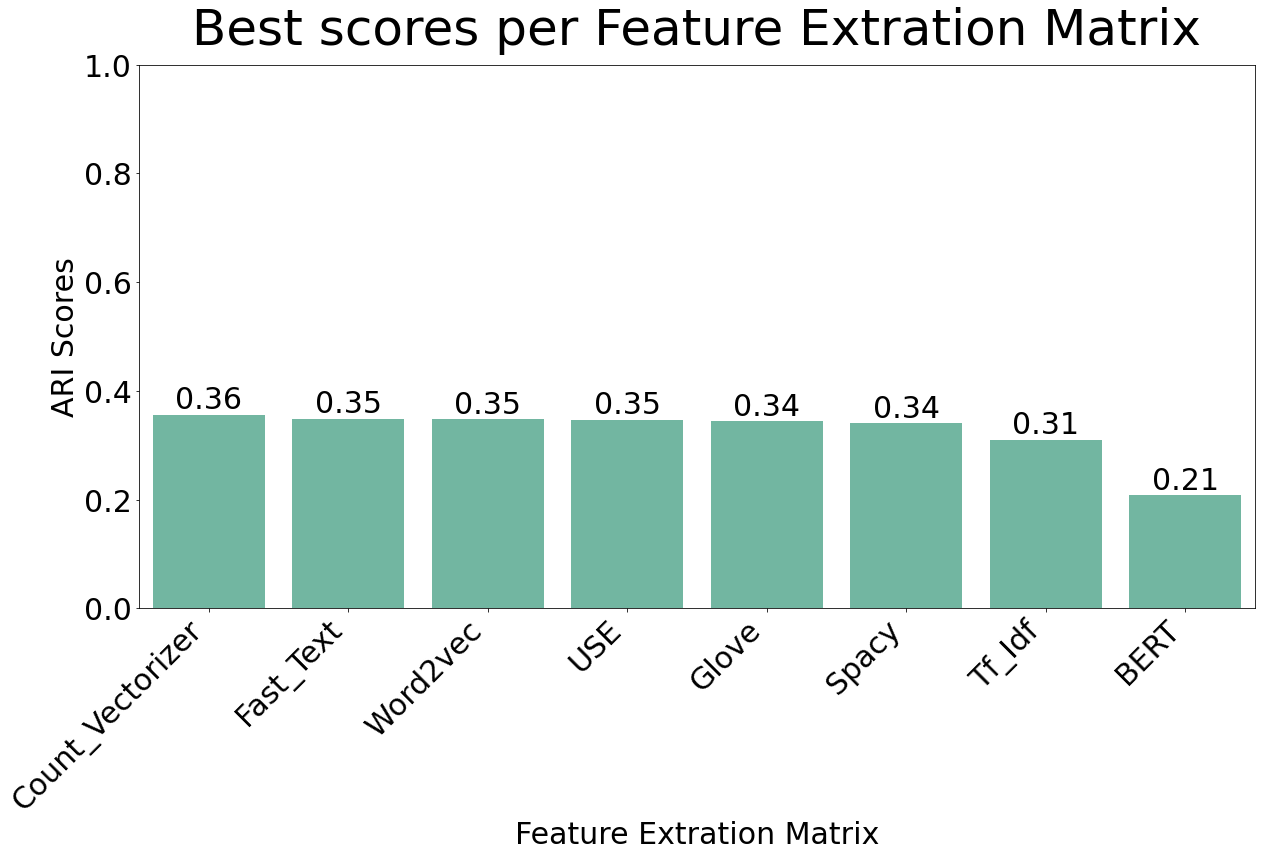

In [35]:
# Plots the best scores per Feature Extration Matrix

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(data=top_per_feature_extraction_df, 
            x='Feature_Extraction',
            y='ARI',
            palette = ['#66c2a5'],
            ax = ax)

for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f', fontsize=text_size)
        
ax.set_ylim((0,1))
ax.set_ylabel('ARI Scores', fontsize=text_size)
ax.set_xlabel('Feature Extration Matrix', fontsize=text_size)

ax.tick_params(labelsize=tick_size)

plt.xticks(rotation=45, ha='right')

plt.title('Best scores per Feature Extration Matrix',
          fontsize=title_size,
          pad=20) 

plt.show();

In [36]:
# Displays the best scores per Dimentionality Reduction Technique

top_per_preprocessing_technique_df = \
    ari_scores_df.loc[
        ari_scores_df['ARI'].sort_values(ascending=False).index]\
    .drop_duplicates(subset=['Preprocessing_name'])

with pd.option_context('display.max_colwidth', None):    
    top_per_preprocessing_technique_df

,Feature_Extraction,ARI,Preprocessing_name,Preprocessing_params,Fit_score
90,Count_Vectorizer,0.356129,PCA TSNE,"{'learning_rate': 300, 'method': 'barnes_hut', 'pca__n_components': 0.5, 'perplexity': 40, 'tsne__n_components': 2}",9.233767
38,Fast_Text,0.348862,PCA,{'pca__n_components': 0.7},0.598999
296,Word2vec,0.322232,SVD,{'svd__n_components': 10},0.563847
265,Count_Vectorizer,0.292484,LDA,{'lda__n_components': 5},3.312330
318,Tf_Idf,0.262904,NMF,{'nmf__n_components': 10},1.682985


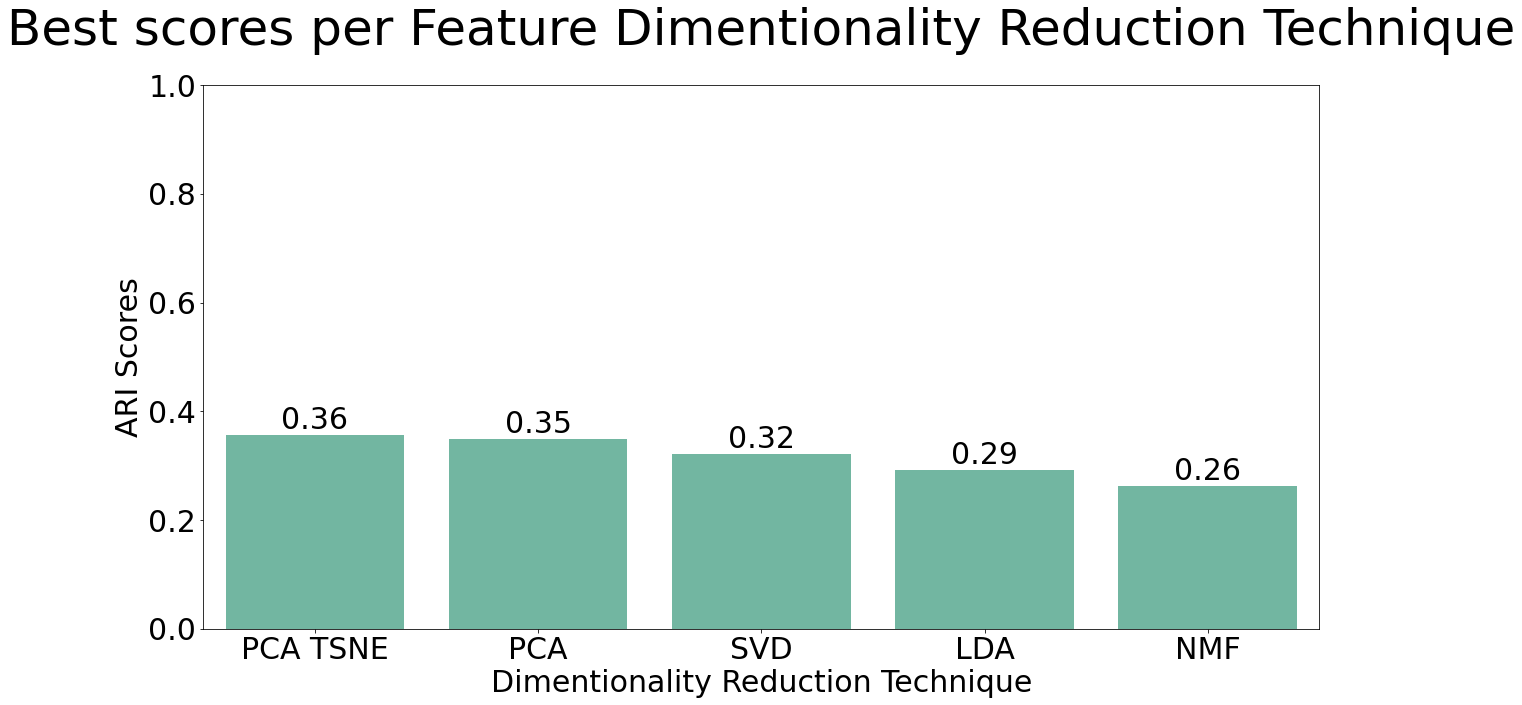

In [37]:
# Plots the best scores per Feature Extration Matrix

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(data=top_per_preprocessing_technique_df, 
            x='Preprocessing_name',
            y='ARI',
            palette = ['#66c2a5'],
            ax = ax)

for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f', fontsize=text_size)
        
ax.set_ylim((0,1))
ax.set_ylabel('ARI Scores', fontsize=text_size)
ax.set_xlabel('Dimentionality Reduction Technique', fontsize=text_size)

ax.tick_params(labelsize=tick_size)

plt.title('Best scores per Feature Dimentionality Reduction Technique',
          fontsize=title_size,
          pad=40) 

plt.show();

<center><h1>Supervised

In [38]:
# Inits a dataframe to commit results of supervised trials

supervised_results_df = pd.DataFrame(columns=['Feature Extraction', 'Accuracy'])

BOW

In [39]:
# Defines BOW Pipelines

count_vectorizer_pipeline = Pipeline([
    ('clean_corpus', CorpusCleaner()),
    ('cv_transformer', CountVectorizer()),
    ('random_forest_clf', RandomForestClassifier(max_depth=10, 
                                                 random_state=random_seed))
])

tf_idf_pipeline = Pipeline([
    ('clean_corpus', CorpusCleaner()),
    ('tf_idf', TfidfVectorizer()),
    ('random_forest_clf', RandomForestClassifier(max_depth=10, 
                                                 random_state=random_seed))
])

In [ ]:
# Grid searches count_vectorizer_pipeline

count_vectorizer_params = [dict()]

count_vectorizer_gs = GridSearchCV(
                           count_vectorizer_pipeline, 
                           count_vectorizer_params, 
                           cv=5, 
                           scoring='accuracy',
                           return_train_score=True,
                           refit=True,
                           verbose=5)

count_vectorizer_gs.fit(X, y);

In [ ]:
# Grid searches tf_idf_pipeline

tf_idf_params = [dict()]

tf_idf_gs = GridSearchCV(tf_idf_pipeline, 
                         tf_idf_params, 
                         cv=5, 
                         scoring='accuracy',
                         return_train_score=True,
                         refit=True,
                         verbose=5)

tf_idf_gs.fit(X, y);

In [42]:
# Commits the above computed results

supervised_results_df.loc[0, ['Feature Extraction', 'Accuracy']] = \
    'CountVectorizer', count_vectorizer_gs.cv_results_['mean_test_score'][0]

supervised_results_df.loc[1, ['Feature Extraction', 'Accuracy']] = \
    'TF-IDF', tf_idf_gs.cv_results_['mean_test_score'][0]

Context Free Embeddings

In [43]:
# Defines context_free_embedding_pipeline

context_free_embedding_pipeline = Pipeline([
    ('corpus_embedder', CorpusEmbedder()),
    ('random_forest_clf', RandomForestClassifier(max_depth=10, 
                                                 random_state=random_seed))
])

In [ ]:
# Grid searches context_free_embedding_pipeline

context_free_embedding_params = [{
    'corpus_embedder__embedder':[word2vec, glove, nlp, fast_text]
}]

context_free_embedding_gs = GridSearchCV(
                           context_free_embedding_pipeline, 
                           context_free_embedding_params, 
                           cv=5, 
                           scoring='accuracy',
                           return_train_score=True,
                           refit=False,
                           verbose=5)

context_free_embedding_gs.fit(X, y);

In [45]:
# Commits the above computed results

supervised_results_df.loc[2, ['Feature Extraction', 'Accuracy']] = \
    'Word2Vec', context_free_embedding_gs.cv_results_['mean_test_score'][0]

supervised_results_df.loc[3, ['Feature Extraction', 'Accuracy']] = \
    'Glove', context_free_embedding_gs.cv_results_['mean_test_score'][1]

supervised_results_df.loc[4, ['Feature Extraction', 'Accuracy']] = \
    'Spacy', context_free_embedding_gs.cv_results_['mean_test_score'][2]

supervised_results_df.loc[5, ['Feature Extraction', 'Accuracy']] = \
    'Fast-Text', context_free_embedding_gs.cv_results_['mean_test_score'][3]

Sentence Embeddings

In [46]:
# Defines sentence_embedding_pipeline

sentence_embedding_pipeline = Pipeline([
    ('sentence_embedder', SentenceEmbedder()),
    ('random_forest_clf', RandomForestClassifier(max_depth=10, 
                                                 random_state=random_seed))
])

In [47]:
# Grid searches sentence_embedding_pipeline

sentence_embedding_pipeline_params = [{
    'sentence_embedder__method':['bert', 'use']
}]

with warnings.catch_warnings():
    
    # UserWarning: User provided device_type of 'cuda', 
    # but CUDA is not available. Disabling
    warnings.simplefilter('ignore')

    sentence_embedding_pipeline_gs = GridSearchCV(
                               sentence_embedding_pipeline, 
                               sentence_embedding_pipeline_params, 
                               cv=5, 
                               scoring='accuracy',
                               return_train_score=True,
                               refit=False,
                               verbose=5)

    sentence_embedding_pipeline_gs.fit(X, y);

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END sentence_embedder__method=bert;, score=(train=0.960, test=0.338) total time= 1.9min
[CV 2/5] END sentence_embedder__method=bert;, score=(train=0.962, test=0.581) total time= 1.9min
[CV 3/5] END sentence_embedder__method=bert;, score=(train=0.948, test=0.576) total time= 1.8min
[CV 4/5] END sentence_embedder__method=bert;, score=(train=0.961, test=0.519) total time= 1.9min
[CV 5/5] END sentence_embedder__method=bert;, score=(train=0.965, test=0.524) total time= 1.8min
[CV 1/5] END sentence_embedder__method=use;, score=(train=0.998, test=0.562) total time= 1.0min
[CV 2/5] END sentence_embedder__method=use;, score=(train=0.996, test=0.752) total time=  56.3s
[CV 3/5] END sentence_embedder__method=use;, score=(train=0.998, test=0.714) total time=  56.9s
[CV 4/5] END sentence_embedder__method=use;, score=(train=0.999, test=0.705) total time=  50.0s
[CV 5/5] END sentence_embedder__method=use;, score=(train=0.998, test=0

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sentence_embedder',
                                        SentenceEmbedder()),
                                       ('random_forest_clf',
                                        RandomForestClassifier(max_depth=10,
                                                               random_state=34))]),
             param_grid=[{'sentence_embedder__method': ['bert', 'use']}],
             refit=False, return_train_score=True, scoring='accuracy',
             verbose=5)

In [48]:
# Commits the above computed results

supervised_results_df.loc[6, ['Feature Extraction', 'Accuracy']] = \
    'BERT', sentence_embedding_pipeline_gs.cv_results_['mean_test_score'][0]

supervised_results_df.loc[7, ['Feature Extraction', 'Accuracy']] = \
    'USE', sentence_embedding_pipeline_gs.cv_results_['mean_test_score'][1]

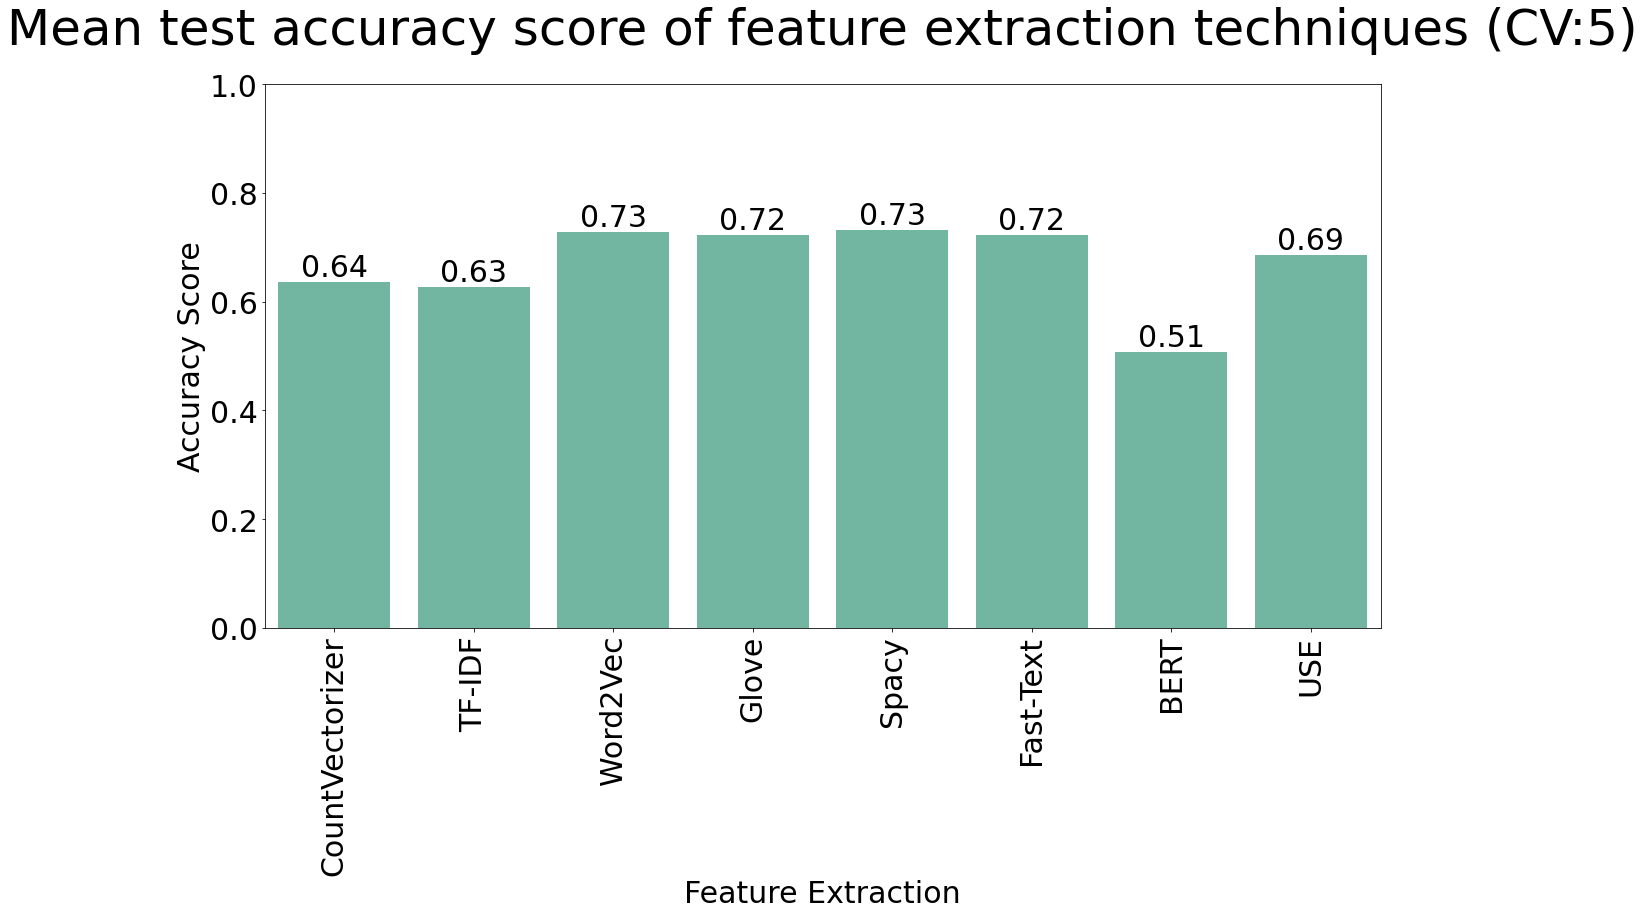

In [49]:
# Plots the best scores per Feature Extration Matrix

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(data=supervised_results_df, 
            x='Feature Extraction',
            y='Accuracy',
            palette = ['#66c2a5'],
            ax = ax)

for bars in ax.containers:
        ax.bar_label(bars, fmt='%.2f', fontsize=text_size)
        
ax.set_ylim((0,1))
ax.set_ylabel('Accuracy Score', fontsize=text_size)
ax.set_xlabel('Feature Extraction', fontsize=text_size)

ax.tick_params(labelsize=tick_size)
ax.tick_params(axis='x', rotation=90)


plt.title('Mean test accuracy score of feature extraction techniques (CV:5)',
          fontsize=title_size,
          pad=40) 

plt.show();